# Etapas de un problema de machine learning

- Definir el problema: ¿Qué se pretende predecir? ¿De qué datos se dispone? o ¿Qué datos es necesario conseguir?

- Explorar y entender los datos que se van a emplear para crear el modelo.

- Métrica de éxito: definir una forma apropiada de cuantificar cómo de buenos son los resultados obtenidos.

- Preparar la estrategia para evaluar el modelo: separar las observaciones en un conjunto de entrenamiento, un conjunto de validación (o validación cruzada) y un conjunto de test. Es muy importante asegurar que ninguna información del conjunto de test participa en el proceso de entrenamiento del modelo.

- Preprocesar los datos: aplicar las transformaciones necesarias para que los datos puedan ser interpretados por el algoritmo de machine learning seleccionado.

- Ajustar un primer modelo capaz de superar unos resultados mínimos. Por ejemplo, en problemas de clasificación, el mínimo a superar es el porcentaje de la clase mayoritaria (la moda). En un modelo de regresión, la media de la variable respuesta.

- Gradualmente, mejorar el modelo incorporando-creando nuevas variables u optimizando los hiperparámetros.

- Evaluar la capacidad del modelo final con el conjunto de test para tener una estimación de la capacidad que tiene el modelo cuando predice nuevas observaciones.

- Entrenar el modelo final con todos los datos disponibles.

### Librerías

In [1]:
#!pip3 install tabulate

In [2]:
#!pip3 install optuna

In [3]:
#!pip3 install fitter


In [4]:
# from .autonotebook import tqdm as notebook_tqdm

In [5]:
# !pip3 install nbconvert


In [6]:
# !pip3 install nbconvert[qtpdf]


### Tratamiento de datos

In [7]:
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import optuna

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

C:\Users\juanj\anaconda3\envs\Machine-Learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Configuración Matplotlib**

In [8]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos

El set de datos SaratogaHouses.csv contiene información sobre el precio de 1728 viviendas situadas en Saratoga County, New York, USA en el año 2006. Además del precio, incluye 15 variables adicionales:

- `price`: precio de la vivienda.
- `lotSize`: metros cuadrados de la vivienda.
- `age`: antigüedad de la vivienda.
- `landValue`: valor del terreno.
- `livingArea`: metros cuadrados habitables.
- `pctCollege`: porcentaje del vecindario con título universitario.
- `bedrooms`: número de dormitorios.
- `firplaces`: número de chimeneas.
- `bathrooms`: número de cuartos de baño (el valor 0.5 hace referencia a cuartos de baño sin ducha).
- `rooms`: número de habitaciones.
- `heating`: tipo de calefacción.
- `fuel`: tipo de alimentación de la calefacción (gas, electricidad o diesel).
- `sewer`: tipo de desagüe.
- `waterfront`: si la vivienda tiene vistas al lago.
- `newConstruction`: si la vivienda es de nueva construcción.
- `centralAir`: si la vivienda tiene aire acondicionado.

**El objetivo es obtener un modelo capaz de predecir el precio del alquiler.**

## Carga y lectura de Datos

In [9]:
datos = pd.read_csv('SaratogaHouses.csv')
datos

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,289000,0.38,32,24200,2310,61,5,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1724,285000,0.94,37,36200,2564,61,4,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1725,194900,0.39,9,20400,1099,51,2,0,1.0,3,hot air,gas,public/commercial,No,No,No
1726,125000,0.24,48,16800,1225,51,3,1,1.0,7,hot air,gas,public/commercial,No,No,No


Vamos a renombrar las columnas para que sean mas descriptivas:

In [10]:
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno", "metros_habitables",
                 "universitarios", "dormitorios", "chimenea", "banyos", "habitaciones",
                 "calefaccion","consumo_calefacion", "desague", "vistas_lago", "nueva_construccion",
                 "aire_acondicionado"]

In [11]:
datos.head(7)

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes
5,120000,0.68,31,14000,1152,22,4,1,1.0,8,hot air,gas,septic,No,No,No
6,153000,0.40,33,23300,2752,51,4,1,1.5,8,hot water/steam,oil,septic,No,No,No


## Análisis exploratorio de Datos (EDA)


Antes de entrenar un modelo predictivo, o incluso antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar una exploración descriptiva de los mismos. Este proceso permite entender mejor qué información contiene cada variable, así como detectar posibles errores. Algunos ejemplos frecuentes son:

- Que una columna se haya almacenado con el tipo incorrecto: una variable numérica está siendo reconocida como texto o viceversa.
- 
Que una variable contenga valores que no tienen sentido: por ejemplo, para indicar que no se dispone del precio de una vivienda se introduce el valor 0 o un espacio en blan.
- Que en una variable de tipo numérico se haya introducido una palabra en lugar de un número.
- Datos Duplicados, Outliers entre otros.ero.

Además, este análisis inicial puede dar pistas sobre qué variables son adecuadas como predictores en un modelo (más sobre esto en los siguientes apartados)

### Tipo de cada columna

En pandas, el tipo "object" hace referencia a strings

In [12]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

## Número de observaciones y valores ausentes

Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores ausentes son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas. Aunque la imputación de valores ausentes es parte del preprocesado y, por lo tanto, debe de aprenderse únicamente con los datos de entrenamiento, su identificación se tiene que realizar antes de separar los datos para asegurar que se establecen todas las estrategias de imputación necesarias.

In [13]:
datos.shape

(1728, 16)

**Número de datos ausentes por variable**

In [14]:
datos.isna().sum().sort_values()

precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
chimenea              0
banyos                0
habitaciones          0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

Ninguna variable contiene valores ausentes. En el apartado **imputación de valores ausentes** se muestra varias estrategias de imputación cuando el set de datos está incompleto.

## Variable respuesta

Cuando se crea un modelo, es muy importante estudiar la *distribución de la variable respuesta*, ya que, a fin de cuentas, es lo que interesa predecir. La variable `precio` tiene una distribución asimétrica con una cola positiva debido a que, unas pocas viviendas, tienen un precio muy superior a la media.

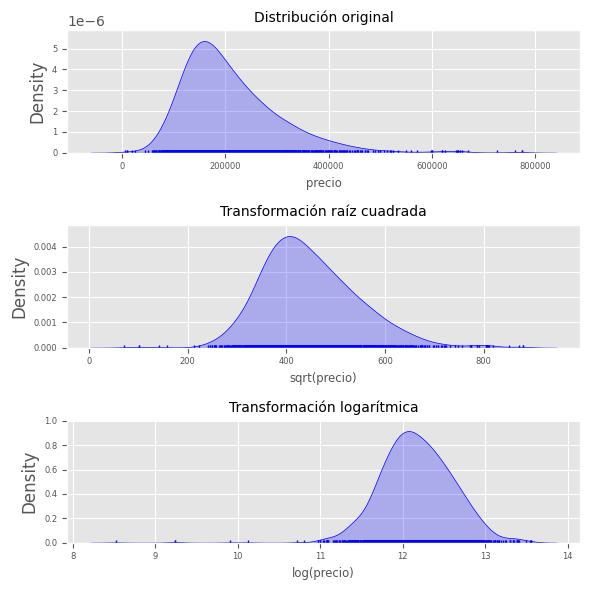

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    datos.precio,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    datos.precio,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('precio', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.sqrt(datos.precio),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(datos.precio),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(precio)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(datos.precio),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(datos.precio),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(precio)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

Algunos modelos de machine learning y aprendizaje estadístico requieren que la variable respuesta se distribuya de una forma determinada. Por ejemplo, para los modelos de regresión lineal (LM), la distribución tiene que ser de tipo normal. Para los modelos lineales generalizados (GLM)(*por ejemplo regresión logistica*), la distribución tiene que ser de la familia exponencial.

Existen varias librerías en python que permiten identificar a qué distribución se ajustan mejor los datos, una de ellas es `fitter`. Esta librería permite ajustar cualquiera de las 80 distribuciones implementadas en `scipy`.

In [16]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(datos.precio, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,2.497420e-11,3068.852573,3090.671453,inf,0.051274,2.180145e-04
logistic,4.913880e-11,3147.967042,3158.876482,inf,0.071310,4.368626e-08
cauchy,5.221450e-11,2956.669693,2967.579133,inf,0.121728,9.001774e-23
chi2,5.835610e-11,3315.562140,3331.926300,inf,0.094392,7.513341e-14
norm,6.947514e-11,3324.534158,3335.443598,inf,0.104149,8.972690e-17
expon,2.915346e-10,2824.103160,2835.012600,inf,0.316530,2.028906e-154
powerlaw,3.132284e-10,2728.809479,2745.173639,inf,0.344929,3.981254e-184
exponpow,4.841645e-10,inf,inf,NaN,1.000000,0.000000e+00
gamma,4.841645e-10,inf,inf,3.958212,0.947917,0.000000e+00


## Variables numéricas

In [17]:
datos.select_dtypes(include=['float64', 'int']).describe()

,precio,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,chimenea,banyos,habitaciones
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,211966.705440,0.500214,27.916088,34557.187500,1754.975694,55.567708,3.154514,0.601852,1.900174,7.041667
std,98441.391015,0.698680,29.209988,35021.168056,619.935553,10.333581,0.817351,0.556102,0.658352,2.316453
min,5000.000000,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,0.000000,0.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1300.000000,52.000000,3.000000,0.000000,1.500000,5.000000
50%,189900.000000,0.370000,19.000000,25000.000000,1634.500000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259000.000000,0.540000,34.000000,40200.000000,2137.750000,64.000000,4.000000,1.000000,2.500000,8.250000
max,775000.000000,12.200000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.500000,12.000000


## Gráfico de distribución para cada variable numérica

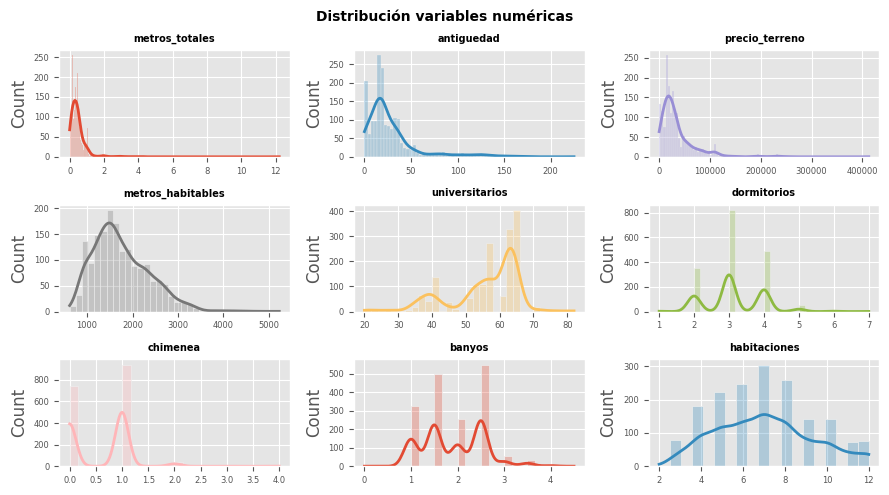

In [18]:
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data     = datos,
        x        = colum,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La variable `chimenea`, aunque es de tipo numérico, apenas toma unos pocos valores y la gran mayoría de observaciones pertenecen a solo dos de ellos. En casos como este, suele ser conveniente tratar la variable como cualitativa.

**Valores observados de chimenea**

In [19]:
datos.chimenea.value_counts()

chimenea
1    942
0    740
2     42
4      2
3      2
Name: count, dtype: int64

**Se convierte la variable chimenea a tipo string**

In [20]:
datos.chimenea = datos.chimenea.astype("str")

Como el objetivo del estudio es predecir el precio de las viviendas, el análisis de cada variable se hace también en relación a la variable respuesta `precio`. Analizando los datos de esta forma, se pueden empezar a extraer ideas sobre qué variables están más relacionadas con el precio y de qué forma.

## Gráfico de distribución para cada variable numérica

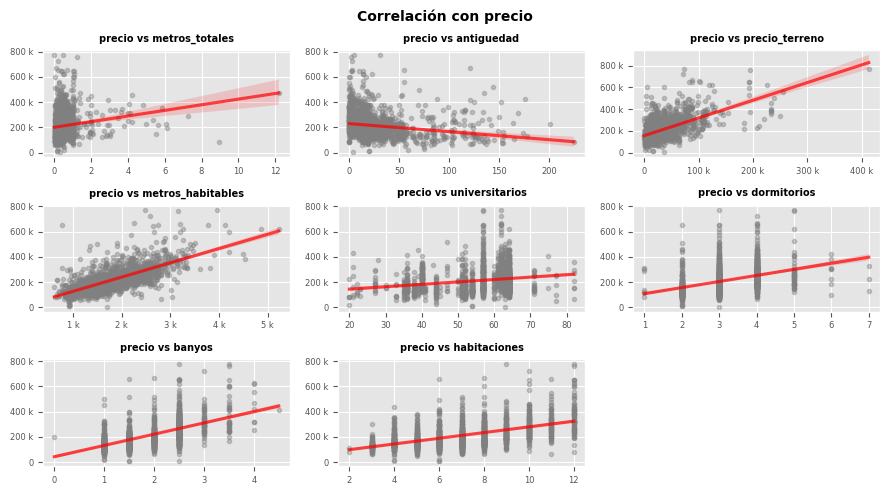

In [21]:
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = datos[colum],
        y           = datos['precio'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");

## Correlación variables numéricas

Algunos modelos (LM, GLM, ...) se ven perjudicados si incorporan predictores altamente correlacionados. Por esta razón, es conveniente estudiar el grado de correlación entre las variables disponibles.

**Correlación entre columnas numéricas**

In [22]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
44,metros_habitables,habitaciones,0.733666,0.733666
76,habitaciones,metros_habitables,0.733666,0.733666
67,banyos,metros_habitables,0.718564,0.718564
43,metros_habitables,banyos,0.718564,0.718564
36,metros_habitables,precio,0.712390,0.712390
4,precio,metros_habitables,0.712390,0.712390
78,habitaciones,dormitorios,0.671863,0.671863
62,dormitorios,habitaciones,0.671863,0.671863
42,metros_habitables,dormitorios,0.656196,0.656196
58,dormitorios,metros_habitables,0.656196,0.656196


**Heatmap matriz de correlaciones**

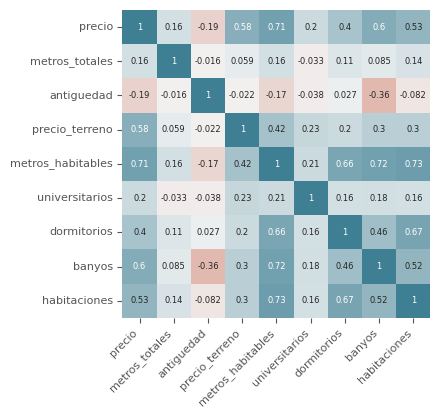

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

## Variables cualitativas

**Variables cualitativas (tipo object)**

In [24]:
datos.select_dtypes(include=['object']).describe()

,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728,1728
unique,5,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,942,1121,1197,1213,1713,1647,1093


**Gráfico para cada variable cualitativa**

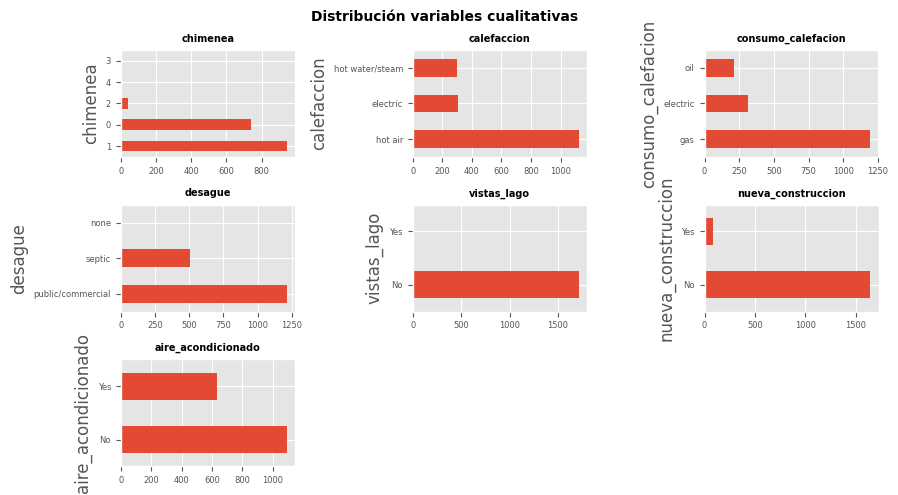

In [25]:
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

Si alguno de los niveles de una variable cualitativa tiene muy pocas observaciones en comparación a los otros niveles, puede ocurrir que, durante la validación cruzada o bootstrapping, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo que puede dar lugar a errores. En estos casos, suele ser conveniente:

- Eliminar las observaciones del grupo minoritario si es una variable multiclase.

- Eliminar la variable si solo tiene dos niveles.

- Agrupar los niveles minoritarios en un único grupo.

- Asegurar que, en la creación de las particiones, todos los grupos estén representados en cada una de ellas.

Para este caso, hay que tener precaución con la variable `chimenea`. Se unifican los niveles de 2, 3 y 4 en un nuevo nivel llamado "2_mas".

In [26]:
datos.chimenea.value_counts().sort_index()

chimenea
0    740
1    942
2     42
3      2
4      2
Name: count, dtype: int64

In [27]:
dic_replace = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

datos['chimenea'] = (
    datos['chimenea']
    .map(dic_replace) 
    .fillna(datos['chimenea'])
)

In [28]:
datos.chimenea.value_counts().sort_index()

chimenea
0        740
1        942
2_mas     46
Name: count, dtype: int64

## Gráfico de la relación entre el precio y cada variable cualitativas

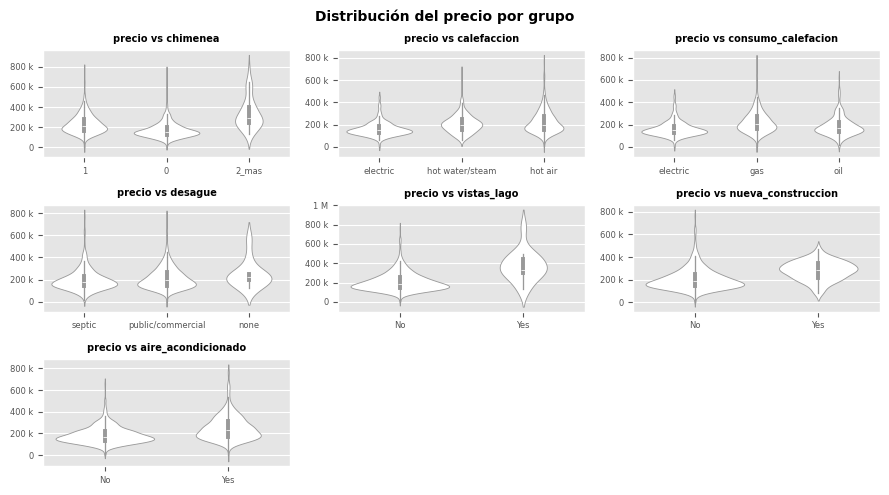

In [29]:
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'precio',
        data  = datos,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del precio por grupo', fontsize = 10, fontweight = "bold");

## División train y test

Evaluar la capacidad predictiva de un modelo consiste en comprobar cómo de próximas son sus predicciones a los verdaderos valores de la variable respuesta. Para poder cuantificarlo de forma correcta, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable respuesta, pero que el modelo no haya "visto", es decir, que no hayan participado en su ajuste. Con esta finalidad, se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de test. El tamaño adecuado de las particiones depende en gran medida de la cantidad de datos disponibles y la seguridad que se necesite en la estimación del error, 80%-20% suele dar buenos resultados. El reparto debe hacerse de forma aleatoria o aleatoria-estratificada.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('precio', axis = 'columns'),
                                        datos['precio'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Es importante verificar que la distribución de la variable respuesta es similar en el conjunto de entrenamiento y en el de test. Para asegurar que esto se cumple, la función train_test_split() de scikit-learn permite, en **problemas de clasificación**, identificar con el argumento `stratify` la variable en base a la cual hacer el reparto.

Este tipo de reparto estratificado asegura que el conjunto de entrenamiento y el de test sean similares en cuanto a la variable respuesta, sin embargo, no garantiza que ocurra lo mismo con los predictores. Por ejemplo, en un set de datos con 100 observaciones, un predictor binario que tenga 90 observaciones de un grupo y solo 10 de otro, tiene un alto riesgo de que, en alguna de las particiones, el grupo minoritario no tenga representantes. Si esto ocurre en el conjunto de entrenamiento, algunos algoritmos darán error al aplicarlos al conjunto de test, ya que no entenderán el valor que se les está pasando. Este problema puede evitarse eliminando variables con varianza próxima a cero (ver más adelante).

**Partición de Entrenamiento**

In [31]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count      1382.000000
mean     211436.516643
std       96846.639129
min       10300.000000
25%      145625.000000
50%      190000.000000
75%      255000.000000
max      775000.000000
Name: precio, dtype: float64


In [32]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count       346.000000
mean     214084.395954
std      104689.155889
min        5000.000000
25%      139000.000000
50%      180750.000000
75%      271750.000000
max      670000.000000
Name: precio, dtype: float64


## Preprocesado de los datos (Data Preprocesing)

El preprocesado engloba todas aquellas transformaciones realizadas sobre los datos con el objetivo que puedan ser interpretados por el algoritmo de machine learning lo más eficientemente posible. Todo preprocesado de datos debe aprenderse con las observaciones de entrenamiento y luego aplicarse al conjunto de entrenamiento y al de test. Esto es muy importante para no violar la condición de que ninguna información procedente de las observaciones de test participe o influya en el ajuste del modelo. Este principio debe aplicarse también si se emplea validación cruzada (ver más adelante). En tal caso, el preprocesado debe realizarse dentro de cada iteración de validación, para que las estimaciones que se hacen con cada partición de validación no contengan información del resto de particiones. Aunque no es posible crear un único listado, a continuación se resumen algunos de los pasos de preprocesado que más se suelen necesitar.

**Imputación de valores ausentes**

La gran mayoría de algoritmos no aceptan observaciones incompletas, por lo que, cuando el set de datos contiene valores ausentes, se puede:

- Eliminar aquellas observaciones que estén incompletas.
- 
Eliminar aquellas variables que contengan valores ausentes.- 

Tratar de estimar los valores ausentes empleando el resto de información disponible (imputaci
  
Las primeras dos opciones, aunque sencillas, suponen perder información. La eliminación de observaciones solo puede aplicarse cuando se dispone de muchas y el porcentaje de registros incompletos es muy bajo. En el caso de eliminar variables, el impacto dependerá de cuánta información aporten dichas variables al modelo. Cuando se emplea la imputación, es muy importante tener en cuenta el riesgo que se corre al introducir valores en predictores que tengan mucha influencia en el modelo. Supóngase un estudio médico en el que, cuando uno de los predictores es positivo, el modelo predice casi siempre que el paciente está sano. Para un paciente cuyo valor de este predictor se desconoce, el riesgo de que la imputación sea errónea es muy alto, por lo que es preferible obtener una predicción basada únicamente en la información disponible. Esta es otra muestra de la importancia que tiene que el analista conozca el problema al que se enfrenta y pueda así tomar la mejor decisión.ón).

El módulo `sklearn.impute` incorpora varios métodos de imputación distintos:

- `SimpleImputer`: permite imputaciones empleando un valor constante o un estadístico (media, mediana, valor más frecuente) de la misma columna en la que se encuentra el valor ausente.
- `IterativeImputer`: permite imputar el valor de una columna teniendo en cuenta el resto de columnas. En concreto, se trata de un proceso iterativo en el que, en cada iteración, una de las variables se emplea como variable respuesta y el resto como predictores. Una vez obtenido el modelo, se emplea para predecir las posiciones vacías de esa variable. Este proceso se lleva a cabo con cada variable y se repite el ciclo `max_iter` veces para ganar estabilidad. La implementación de `sklearn.impute.IterativeImputer` permite que se emplee casi cualquiera de sus algoritmos para crear los modelos de imputación (KNN, RandomForest, GradientBoosting...).
- `KNNImputer`: es un caso concreto de `IterativeImputer` en el que se emplea k-Nearest Neighbors como algoritmo de imputación.el modelo.

A pesar de ser un método muy utilizado, imputar utilizando KNN presenta dos problemas: su coste computacional elevado hace que solo sea aplicable en conjuntos de datos de tamaño pequeño o moderado. Si hay variables categóricas, debido a la dificultad de medir "distancias" en este contexto, puede dar lugar a resultados poco realistas. Por estas dos razones, es más recomendable utilizar un modelo tipo *Random Forest* `IterativeImputer(predictor = RandomForestRegressor())`.

Con el argumento `add_indicator=True` se crea automáticamente una nueva columna en la que se indica con el valor 1 qué valores han sido imputados. Esto puede ser útil tanto para identificar las observaciones en las que se ha realizado alguna imputación como para utilizarla como un predictor más en el modelo.

## Exclusión de variables con varianza próxima a cero

No se deben incluir en el modelo predictores que contengan un único valor (cero-varianza) ya que no aportan información. Tampoco es conveniente incluir predictores que tengan una varianza próxima a cero, es decir, predictores que toman solo unos pocos valores, de los cuales, algunos aparecen con muy poca frecuencia. El problema con estos últimos es que pueden convertirse en predictores con varianza cero cuando se dividen las observaciones por validación cruzada o bootstrap.

La clase `VarianceThreshold` del módulo `sklearn.feature_selection` identifica y excluye todos aquellos predictores cuya varianza no supera un determinado threshold. En el caso de variables cualitativas, cabe recordar que scikitlearn requiere que se binaricen (`one hot encoding` o *dummy*) para poder entrenar los modelos. Una variable booleana sigue una distribución de Bernoulli, por lo que su varianza puede ser calculada como:

$Var[X]=p(1-p)$

Si bien la eliminación de predictores no informativos podría considerarse un paso propio del proceso de selección de predictores, dado que consiste en un filtrado por varianza, tiene que realizarse antes de estandarizar los datos, ya que después, todos los predictores tienen varianza 1.

## Estandarización y escalado de variables numéricas

Cuando los predictores son numéricos, la escala en la que se miden, así como la magnitud de su varianza pueden influir en gran medida en el modelo. Muchos algoritmos de machine learning (SVM, redes neuronales, lasso...) son sensibles a esto, de forma que, si no se igualan de alguna forma los predictores, aquellos que se midan en una escala mayor o que tengan más varianza dominarán el modelo aunque no sean los que más relación tienen con la variable respuesta. Existen principalmente 2 estrategias para evitarlo:

- **Centrado**: consiste en restarle a cada valor la media del predictor al que pertenece. Si los datos están almacenados en un dataframe, el centrado se consigue restándole a cada valor la media de la columna en la que se encuentra. Como resultado de esta transformación, todos los predictores pasan a tener una media de cero, es decir, los valores se centran en torno al origen. `StandardScaler(with_std=False)`
  
- **Normalización (estandarización):** consiste en transformar los datos de forma que todos los predictores estén aproximadamente en la misma escala. Hay dos formas de lograrlo:
  - Normalización Z-score (`StandardScaler`) dividir cada predictor entre su desviación típica después de haber sido centrado, de esta forma, los datos pasan a tener una distribución normal.
    
    $ z=\frac{x-\mu }{\sigma }$
    
  - Estandarización max-min (`MinMaxScaler`): transformar los datos de forma que estén dentro del rango [0, 1].
    
    $ X_{norm}=\frac{X-x_{min} }{x_{max}-x_{min} }$

Nunca se deben estandarizar las variables después de ser binarizadas (ver a continuación).

## Binarización de las variables cualitativas

La binarización (one-hot-encoding) consiste en crear nuevas variables dummy con cada uno de los niveles de las variables cualitativas. Por ejemplo, una variable llamada color que contenga los niveles rojo, verde y azul, se convertirá en tres nuevas variables (color_rojo, color_verde, color_azul), todas con el valor 0 excepto la que coincide con la observación, que toma el valor 1.

Por defecto, la clase `OneHotEncoder` binariza todas las variables, por lo que hay que aplicarlo únicamente a las variables cualitativas (ver como hacerlo en el apartado ColumnTransformer). Con el argumento `drop=‘first’` se elimina uno de los niveles para evitar redundancias. Volviendo al ejemplo anterior, no es necesario almacenar las tres variables, ya que, si color_rojo y color_verde toman el valor 0, la variable color_azul toma necesariamente el valor 1. Si color_rojo o color_verde toman el valor 1, entonces color_azul es necesariamente 0. Esto es importante en modelos que sufren problemas si los predictores están perfectamente correlacionados (modelos lineales sin regularización, redes neuronales...).

En ciertos escenarios puede ocurrir que, en los datos de test, aparezca un nuevo nivel que no estaba en los datos de entrenamiento. Si no se conoce de antemano cuáles son todos los posibles niveles, se puede evitar errores en las predicciones indicando `OneHotEncoder(handle_unknown='ignore')`.

La forma de preprocesar los datos dentro del ecosistema scikit-learn es empleando los `ColumnTransformer` y `pipeline`. Además de las ya mencionadas, pueden encontrarse muchas más transformaciones de preprocesado en el módulo sklearn.preprocessing.

## Pipeline y ColumnTransformer

Las clases `ColumnTransformer` y `make_column_transformer` del módulo `sklearn.compose` permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo `transformer`, tiene un método de entrenamiento (`fit`) y otro de transformación (`transform`) . Esto permite que el aprendizaje de las transformaciones se haga únicamente con observaciones de entrenamiento, y se puedan aplicar después a cualquier conjunto de datos. La idea detrás de este módulo es la siguiente:

1.  Definir todas las transformaciones (escalado, selección, filtrado...) que se desea aplicar y a qué columnas `ColumnTransformer()`. La selección de columnas puede hacerse por: nombre. índice, máscara booleana, slice, patrón regex, por tipo de columna o con las funciones de selección `make_column_selector`.

2. Aprender los parámetros necesarios para dichas transformaciones con las observaciones de entrenamiento `.fit()`.

3. Aplicar las transformaciones aprendidas a cualquier conjunto de datos `.transform()`.

**Seleccion de las variables por tipo**

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector


Se estandarizan las columnas numéricas y se hace one-hot-encoding de las  columnas cualitativas. Para mantener las columnas a las que no se les aplica 
ninguna transformación se tiene que indicar `remainder='passthrough'`.

In [34]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

Una vez que se ha definido el objeto `ColumnTransformer`, con el método `fit()` se aprenden las transformaciones con los datos de entrenamiento y se aplican a los dos conjuntos con `transform()`.

In [35]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

Por defecto, el resultado devuelto por `ColumnTransformer` es un numpy array, por lo que se pierden los nombres de las columnas. Suele ser interesante poder inspeccionar cómo queda el set de datos tras el preprocesado en formato dataframe. Por defecto, `OneHotEncoder` ordena las nuevas columnas de izquierda a derecha por orden alfabético.

**Convertir el output en dataframe y añadir el nombre de las columnas**

In [36]:
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
nombre_columnas = np.concatenate([numeric_cols, encoded_cat])
X_train_prep = preprocessor.transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=nombre_columnas)
X_train_prep.head(3)

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones,chimenea_0,chimenea_1,...,consumo_calefacion_oil,desague_none,desague_public/commercial,desague_septic,vistas_lago_No,vistas_lago_Yes,nueva_construccion_No,nueva_construccion_Yes,aire_acondicionado_No,aire_acondicionado_Yes
0,-0.061549,0.301597,-0.195148,1.320467,0.826826,1.011039,0.905289,2.128665,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.195573,-0.407560,-0.277982,0.194931,0.730235,1.011039,1.663079,1.264569,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.072475,-0.478476,-0.892092,-0.064313,-1.877728,1.011039,0.147500,-0.463623,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


A partir de la versión 1.2.1, scikit-learn incluye la posibilidad de que el resultado de los transformers sea un DataFrame de Pandas en lugar de un numpy array. Esto tiene la ventaja de que el resultado de toda transformación incorpora directamente el nombre de las columnas. Este comportamiento se puede indicar a nivel individual de transformer con el método `.set_output(transform="pandas")` o como una configuración global con `set_config(transform_output="pandas")` 

Cabe destacar que, si se utiliza un transformer de tipo `OneHotEncoder` en combinación con `.set_output(transform="pandas")`, se tiene que indicar que el `OneHotEncoder` no devuelva los datos en forma de matriz sparse `sparse_output = False` 


In [37]:
preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

X_train_prep.head(3)

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones,chimenea_0,chimenea_1,...,consumo_calefacion_oil,desague_none,desague_public/commercial,desague_septic,vistas_lago_No,vistas_lago_Yes,nueva_construccion_No,nueva_construccion_Yes,aire_acondicionado_No,aire_acondicionado_Yes
1571,-0.061549,0.301597,-0.195148,1.320467,0.826826,1.011039,0.905289,2.128665,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
832,-0.195573,-0.407560,-0.277982,0.194931,0.730235,1.011039,1.663079,1.264569,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1302,0.072475,-0.478476,-0.892092,-0.064313,-1.877728,1.011039,0.147500,-0.463623,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


`ColumnTransformer` aplica las operaciones de forma paralela, no de forma secuencial, esto significa que no permite aplicar más de una transformación a una misma columna. En el caso de que sea necesario hacerlo, hay que recurrir a los `pipeline`, que también agrupan operaciones pero las ejecutan de forma secuencial, de forma que la salida de una operación es la entrada de la siguiente. Si se quieren aplicar varias transformaciones de preprocesado sobre una misma columna, es necesario agruparlas primero en un `pipeline`

En el siguiente ejemplo se combinan las transormaciones:

- Columnas numéricas: se imputan los valores ausentes con la mediana y a continuación se estandarizan.
  
- Columnas categóricas (cualitativas): se imputan los valores ausentes con el valor más frecuente y a continuación se aplica one hot encoding.

**Selección de las variables por tipo**

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()



**Transformaciones para las variables numéricas**

In [39]:

numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )

**Transformaciones para las variables categóricas**

In [40]:
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [41]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)
X_train_prep.head(3)

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones,chimenea_0,chimenea_1,...,consumo_calefacion_oil,desague_none,desague_public/commercial,desague_septic,vistas_lago_No,vistas_lago_Yes,nueva_construccion_No,nueva_construccion_Yes,aire_acondicionado_No,aire_acondicionado_Yes
1571,-0.061549,0.301597,-0.195148,1.320467,0.826826,1.011039,0.905289,2.128665,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
832,-0.195573,-0.407560,-0.277982,0.194931,0.730235,1.011039,1.663079,1.264569,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1302,0.072475,-0.478476,-0.892092,-0.064313,-1.877728,1.011039,0.147500,-0.463623,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


A partir de las versión `scikit-learn 0.23` se puede crear una representación interactiva de un objeto `pipeline`.

In [42]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['metros_totales', 'antiguedad',
                                  'precio_terreno', 'metros_habitables',
                                  'universitarios', 'dormitorios', 'banyos',
                                  'habitaciones']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['chimenea', 'calefaccion',
                                  'consumo_calefacion', 'desague',
                                  'vistas_lago', 'nueva_construccion',
                                  'aire_acondicionado'])],
                  verbose_feature_names_out=False)

In [43]:
set_config(display='text')

## Crear un modelo 

El siguiente paso tras definir los datos de entrenamiento, es seleccionar el algoritmo que se va a emplear. En scikit-learn, esto se hace mediante la creación de un objeto estimator. En concreto, este objeto almacena el nombre del algoritmo, sus parámetros e hiperparámetros y contiene los métodos fit(X, y) y predict(T) que le permiten aprender de los datos y predecir nuevas observaciones. El siguiente [listado](https://scikit-learn.org/stable/user_guide.html) contiene todos los algoritmos implementados en scikit-learn.

### Entrenamiento

Se ajusta un primer modelo de regresión lineal con regularización ridge para predecir el precio de la vivienda en función de todos los predictores disponibles. Todos los argumentos de `sklearn.linear_model.Ridge` se dejan por defecto.

Es importante tener en cuenta que, cuando un modelo de regresión lineal incluye regularización en los coeficientes (ridge, lasso, elasticnet), deben estandarizarse los predictores. Para asegurar que el preprocesado se realiza únicamente con los datos de entrenamiento, se combinan las transformaciones y el entrenamiento en un mismo `pipeline`.


In [44]:
from sklearn.linear_model import Ridge

**Preprocesado**

*Identificación de columnas numéricas*

In [45]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


*Transformaciones para las variables numéricas*

In [46]:
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

*Transformaciones para las variables categóricas*

In [47]:
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

*Transformer*

In [48]:
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

*Pipeline*

Se combinan los pasos de preprocesado y el modelo en un mismo pipeline

In [49]:
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

*Train*

Se asigna el resultado a `_` para que no se imprima por pantalla

In [50]:
_ = pipe.fit(X=X_train, y=y_train)

## Validación

La finalidad última de un modelo es predecir la variable respuesta en observaciones futuras o en observaciones que el modelo no ha "visto" antes. El error mostrado por defecto tras entrenar un modelo suele ser el error de entrenamiento, el error que comete el modelo al predecir las observaciones que ya ha "visto". Si bien estos errores son útiles para entender cómo está aprendiendo el modelo (estudio de residuos), no es una estimación realista de cómo se comporta el modelo ante nuevas observaciones (el error de entrenamiento suele ser demasiado optimista). Para conseguir una estimación más certera, y antes de recurrir al conjunto de test, se pueden emplear estrategias de validación basadas en `resampling`. Scikit-learn incorpora en el módulo `sklearn.model_selection` varias estrategias de validación.

- Todas ellas reciben como primer argumento un estimator que puede ser directamente un modelo o un pipeline.

- Las métricas de error de regresión se devuelven siempre en negativo de forma que, cuanto más próximo a 0 sea el valor, mejor el ajuste. Esto es así para que, los procesos de optimización siempre sean de maximización.

La forma más sencilla es emplear la función `cross_val_score()`, que utiliza por defecto `KFold`.

**Validación cruzada**

In [51]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-53936.97817183 -53076.74364513 -62746.15219054 -65963.09754244
 -48929.66260476]
Média métricas de validación cruzada: -56930.52683094099


También es posible utilizar otras estrategias de validación cruzada (*KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit*) realizando previamente el reparto con las funciones auxiliares de `sklearn.model_selection` y pasando los índices al argumento `cv`.

Cada método funciona internamente de forma distinta, pero todos ellos se basan en la idea: ajustar y evaluar el modelo de forma repetida, empleando cada vez distintos subconjuntos creados a partir de los datos de entrenamiento y obteniendo en cada repetición una estimación del error. El promedio de todas las estimaciones tiende a converger en el valor real del error de test

**Validación cruzada repetida**

In [52]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
            )

print(f"Métricas de validación cruzada: {cv_scores}")
print("")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas de validación cruzada: [-66487.72274814 -56333.87119132 -48992.85039086 -55030.00923381
 -58790.48472729 -62651.67080028 -55779.2103529  -61820.5882113
 -57243.1819794  -48910.70385765 -50033.46929956 -51586.8240037
 -62478.2206031  -65111.86204296 -54900.98944223 -64220.39882006
 -53694.93490461 -64690.99877883 -51242.27642488 -52330.80605289
 -56777.05219272 -58644.60923875 -55573.25900549 -64350.25804164
 -50578.15339623]

Média métricas de validación cruzada: -57130.17622962478


La función `cross_validate` es similar a `cross_val_score` pero permite estimar varias métricas a la vez, tanto para test como para train, y devuelve los resultados en un diccionario.

**Validación cruzada repetida con múltiples métricas**

In [53]:
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.022760,0.011641,0.632359,0.679758,-64605.636258,-51789.256510
1,0.027221,0.014575,0.718708,0.636812,-48322.428406,-59983.019196
2,0.029438,0.009214,0.595874,0.689939,-58434.926618,-55213.669996
3,0.024387,0.007949,0.672969,0.655316,-58179.173708,-55331.536238
4,0.019617,0.010114,0.615521,0.683390,-60148.310664,-54366.426683
5,0.016653,0.014040,0.650829,0.664771,-53812.579173,-57561.184588
6,0.020213,0.015461,0.698178,0.647441,-49813.241120,-59221.407345
7,0.016957,0.010463,0.646554,0.673016,-61749.477863,-53221.315710
8,0.021741,0.010467,0.615151,0.682999,-59192.994923,-54895.180113
9,0.026310,0.013760,0.645685,0.670425,-61061.033083,-53843.654748


**Distribución del error de validación cruzada**

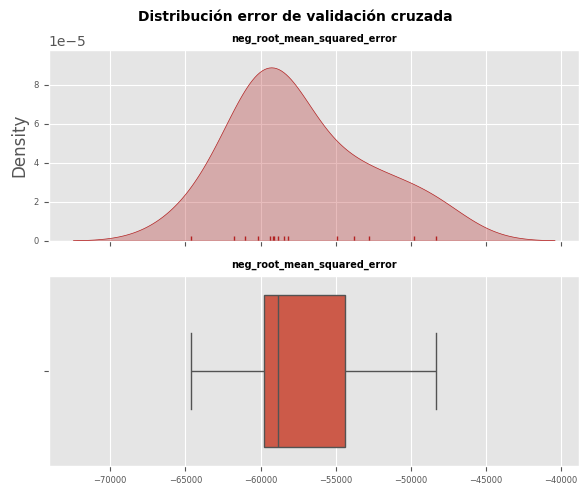

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.kdeplot(
    cv_scores['test_neg_root_mean_squared_error'],
    fill    = True,
    alpha   = 0.3,
    color   = "firebrick",
    ax      = axes[0]
)
sns.rugplot(
    cv_scores['test_neg_root_mean_squared_error'],
    color   = "firebrick",
    ax      = axes[0]
)
axes[0].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[0].tick_params(labelsize = 6)
axes[0].set_xlabel("")
    
sns.boxplot(
    x  = cv_scores['test_neg_root_mean_squared_error'],
    ax = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[1].tick_params(labelsize = 6)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución error de validación cruzada', fontsize = 10,
             fontweight = "bold");

La función `cross_val_predict`, en lugar de devolver la métrica de cada partición, devuelve las predicciones de cada partición. Esto es útil para poder evaluar los residuos del modelo y diagnosticar su comportamiento. Si se emplea validación cruzada repetida o bootstrapping, una misma observación puede formar parte de la partición de validación varias veces.

**Diagnóstico errores (residuos) de las predicciones de validación cruzada**

In [55]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import statsmodels.api as sm

*Validación cruzada*

In [56]:
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_prediccones = cross_val_predict(
                    estimator = pipe,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                 )

*Gráficos*

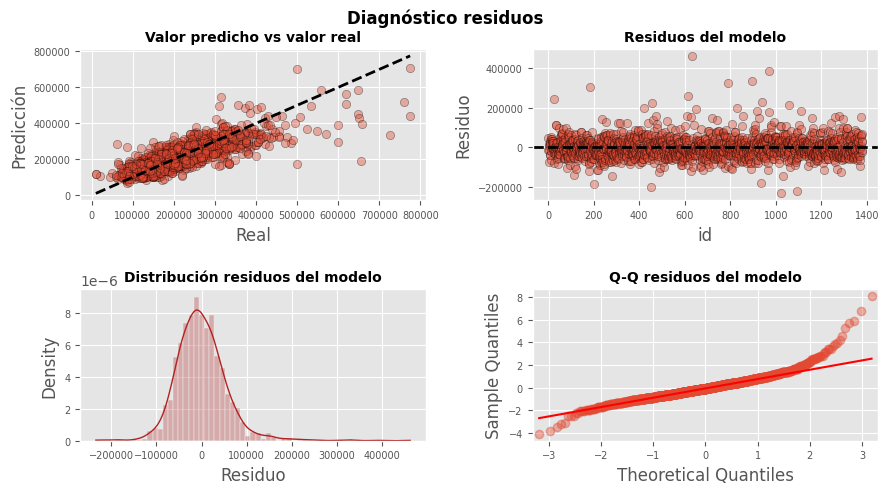

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))

axes[0, 0].scatter(y_train, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    'k--', color = 'black', lw=2
)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), y_train - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

A efectos prácticos, cuando se aplican métodos de `resampling` para validar un modelo hay que tener en cuenta dos cosas: el coste computacional que implica ajustar múltiples veces un modelo, cada vez con un subconjunto de datos distinto, y la reproducibilidad en la creación de las particiones. Las funciones `cross_val_score()` y `cross_val_predict` permiten paralelizar el proceso mediante el argumento `n_jobs`.

*Validación cruzada repetida paralelizada (multicore)*

In [58]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv,
                n_jobs    = -1 # todos los cores disponibles
            )

print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Média métricas de validación cruzada: -56735.77500472445


El *root_mean_squared_error* promedio estimado mediante validación cruzada para el modelo ridge es de 56735. Este valor será contrastado más adelante cuando se calcule el error del modelo con el conjunto de test.

## Predicción

Una vez que el modelo ha sido entrenado, bien empleando directamente un `estimator` o un `pipeline`, con el método `.predict()` se pueden predecir nuevas observaciones. Si se emplea un `pipeline`, se aplican automáticamente las transformaciones aprendidas durante el entrenamiento. 

In [59]:
predicciones = pipe.predict(X_test)

**Se crea un dataframe con las predicciones y el valor real**

In [60]:
df_predicciones = pd.DataFrame({'precio' : y_test, 'prediccion' : predicciones})
df_predicciones.head()

,precio,prediccion
903,105000,112491.665253
208,113000,185142.195564
358,110500,168900.516039
1187,159000,139333.302565
319,215000,236967.476884


## Error de test

Aunque mediante los métodos de validación (*Kfold*, *LeaveOneOut*) se consiguen buenas estimaciones del error que tiene un modelo al predecir nuevas observaciones, la mejor forma de evaluar un modelo final es prediciendo un conjunto test, es decir, un conjunto de observaciones que se ha mantenido al margen del proceso de entrenamiento y optimización. Dependiendo del problema en cuestión, pueden ser interesantes unas métricas
  u otras. El módulo [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) incorpora una variedad considerable de métricas para evaluar la calidad de las predicciones.

**Error cuadrático medio del conjunto test** 

In [61]:
# mean_squared_error de test
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
rmse

65372.91638923964

En el apartado de validación, se estimó, mediante validación cruzada repetida, que el rmse del modelo era de 56735, un valor próximo al obtenido con el conjunto de test 65372.

## Hiperparámetros (tuning)

Muchos modelos, entre ellos la regresión lineal con regularización Ridge, contienen parámetros que no pueden aprenderse a partir de los datos de entrenamiento y, por lo tanto, deben de ser establecidos por el analista. A estos se les conoce como hiperparámetros. Los resultados de un modelo pueden depender en gran medida del valor que tomen sus hiperparámetros, sin embargo, no se puede conocer de antemano cuál es el adecuado. Aunque con la práctica, los especialistas en machine learning ganan intuición sobre qué valores pueden funcionar mejor en cada problema, no hay reglas fijas. La forma más común de encontrar los valores óptimos es probando diferentes posibilidades.

1. Escoger un conjunto de valores para el o los hiperparámetros.
   - `grid search`: se hace una búsqueda exhaustiva sobre un conjunto de valores previamente definidos por el usuario.
   - `random search`: se evalúan valores aleatorios dentro de unos límites definidos por el usuario.
2. Para cada valor (combinación de valores si hay más de un hiperparámetro), entrenar el modelo y estimar su error mediante un método de validación.
3. Finalmente, ajustar de nuevo el modelo, esta vez con todos los datos de entrenamiento y con los mejores hiperparámetros encontrados.

`Scikilearn` permite explorar diferentes valores de hiperparámetros mediante `model_selection.GridSearchCV()` y `model_selection.RandomizedSearchCV()`

### Grid Search

El modelo **Ridge** empleado hasta ahora tiene un hiperparámetro llamado `alpha`, que por defecto tiene el valor 1.0. Este hiperparámetro controla la penalización que se aplica a los coeficientes del modelo. Cuanto mayor es su valor, más restricción se impone sobre los coeficientes, reduciendo así varianza, atenuando el efecto de la correlación entre predictores y minimizando el riesgo de *overfitting*.

Se vuelve a ajustar un modelo Ridge con diferentes valores de `alpha` empleando validación cruzada repetida para identificar con cuál se obtienen mejores resultados.

In [62]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge

**Pipe: preprocesado + modelo**

- Identificación de columnas numéricas y catégoricas

In [63]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

- Transformaciones para las variables numéricas

In [64]:
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

- Transformaciones para las variables categóricas

In [65]:
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

- Se combinan los pasos de preprocesado y el modelo en un mismo pipeline

In [66]:
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

**Grid de hiperparámetros**

In [67]:
param_grid = {'modelo__alpha': np.logspace(-5, 3, 10)}

- Búsqueda por validación cruzada

In [68]:
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

- Se asigna el resultado a `_` para que no se imprima por pantalla

In [69]:
_ = grid.fit(X = X_train, y = y_train)

**Resultados del grid**

In [70]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,-56970.445916,4418.175726,-55927.874903,1134.881454
5,0.278256,-57005.216711,4371.468635,-55915.004214,1134.763145
4,0.035938,-57013.010756,4365.524530,-55914.737159,1134.764913
3,0.004642,-57014.089077,4364.763938,-55914.732566,1134.764954
2,0.000599,-57014.229588,4364.665841,-55914.732489,1134.764955
1,0.000077,-57014.247757,4364.653173,-55914.732488,1134.764955
0,0.00001,-57014.250104,4364.651537,-55914.732488,1134.764955
7,16.681005,-57097.924468,4650.962813,-56182.884195,1148.730719
8,129.154967,-58005.790065,4960.766701,-57357.816628,1207.601278
9,1000.0,-62585.778570,5587.506060,-62380.994562,1259.080713


**Mejores hiperparámetros**

In [71]:
print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(f"{grid.best_params_} : {grid.best_score_} ({grid.scoring})")

-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'modelo__alpha': 2.154434690031882} : -56970.445915507444 (neg_root_mean_squared_error)


**Gráfico resultados validación cruzada para cada hiperparámetro**

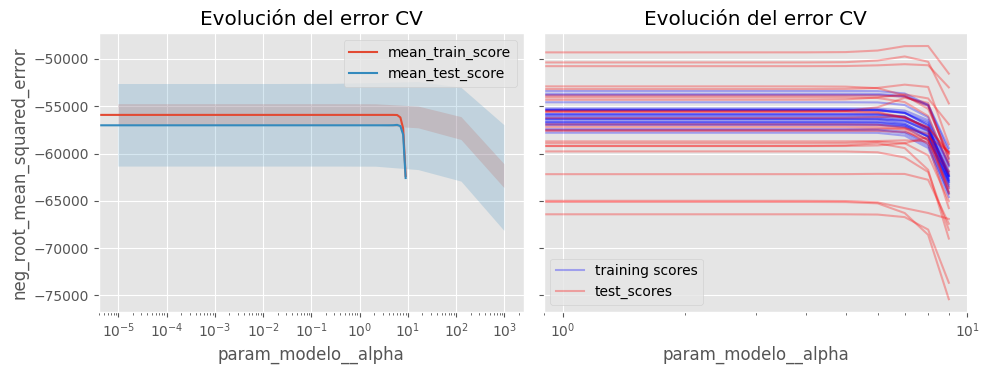

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.84), sharey=True)

# Gráfico 1
# ------------------------------------------------------------------------------
resultados.plot('param_modelo__alpha', 'mean_train_score', ax=axes[0])
resultados.plot('param_modelo__alpha', 'mean_test_score', ax=axes[0])
axes[0].fill_between(resultados.param_modelo__alpha.astype(float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
axes[0].fill_between(resultados.param_modelo__alpha.astype(float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Evolución del error CV')
axes[0].set_ylabel('neg_root_mean_squared_error');

# Gráfico 2
# ------------------------------------------------------------------------------
numero_splits = grid.n_splits_

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_train_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'blue', 
    ax    = axes[1]
)

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_test_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'red', 
    ax    = axes[1]
)

axes[1].legend(
    (axes[1].get_children()[0], axes[1].get_children()[numero_splits]),
    ('training scores', 'test_scores')
)
axes[1].set_xscale('log')
axes[1].set_title('Evolución del error CV')
axes[1].set_ylabel('neg_root_mean_squared_error');

fig.tight_layout()

**Comparación de hiperparámetros**

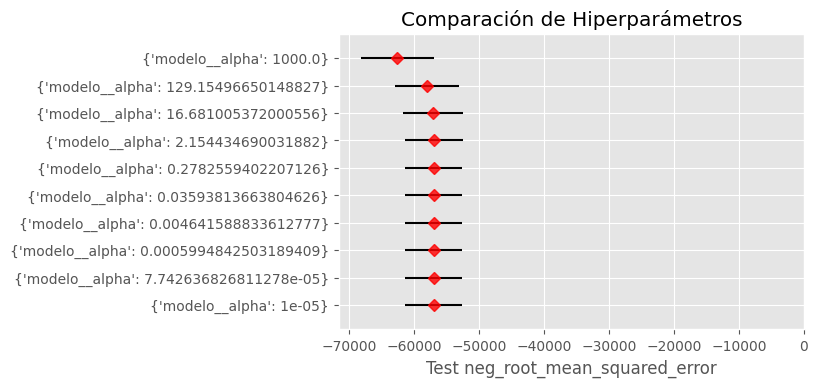

In [73]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.barh(
    [str(d) for d in resultados['params']],
    resultados['mean_test_score'],
    xerr=resultados['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    resultados['mean_test_score'],
    [str(d) for d in resultados['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Comparación de Hiperparámetros')
ax.set_xlabel('Test neg_root_mean_squared_error');

Si en `GridSearchCV()` se indica `refit=True`, tras identificar los mejores hiperparámetros, se reentrena el modelo con ellos y se almacena en `.best_estimator_`.

## Random grid search

`GridSearchCV()` hace una búsqueda exhaustiva evaluando todas las combinaciones de parámetros. Esta estrategia tiene el inconveniente de que se puede invertir mucho tiempo en regiones de poco interés antes de evaluar otras combinaciones. Una alternativa es hacer una búsqueda aleatoria, de esta forma, se consigue explorar el espacio de búsqueda de una forma más distribuida. `RandomizedSearchCV()` permite este tipo de estrategia, únicamente requiere que se le indique el espacio de búsqueda de cada hiperparámetro (lista de opciones o una distribución) y el número de combinaciones aleatorias a evaluar.

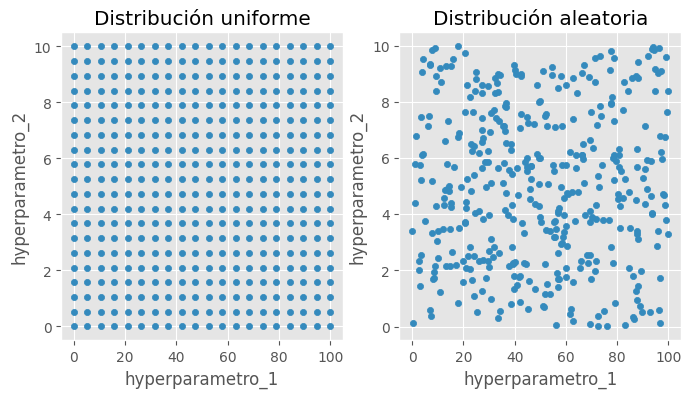

In [74]:
from itertools import product
import random

fig, axs = plt.subplots(nrows = 1, ncols = 2,figsize=(8, 4),
                        sharex = True, sharey = False)
# Grid exhaustivo
# ==============================================================================
hyperparametro_1 = np.linspace(start = 0, stop = 100, num=20)
hyperparametro_2 = np.linspace(start = 0, stop = 10, num=20)

# Lista con todas las combinaciones
combinaciones = [list(x) for x in product(hyperparametro_1, hyperparametro_2)]
combinaciones = pd.DataFrame.from_records(
                    combinaciones,
                    columns=['hyperparametro_1', 'hyperparametro_2']
                )

combinaciones.plot(
    x    = 'hyperparametro_1',
    y    = 'hyperparametro_2',
    kind = 'scatter',
    ax   = axs[0]
)
axs[0].set_title('Distribución uniforme')

# Grid aleatorio (random grid)
# ==============================================================================
hyperparametro_1 = np.random.uniform(low = 0, high = 100, size  = 400)
hyperparametro_2 = np.random.uniform(low = 0, high = 10, size  = 400)

combinaciones = pd.DataFrame(
                    {
                    'hyperparametro_1': hyperparametro_1,
                    'hyperparametro_2': hyperparametro_2,
                    }
                )
combinaciones.plot(
    x    = 'hyperparametro_1',
    y    = 'hyperparametro_2',
    kind = 'scatter',
    ax   = axs[1]
)
axs[1].set_title('Distribución aleatoria');

In [75]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {'modelo__alpha': np.logspace(-5, 3, 100)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
33,3.764936,-57065.294676,3748.530538,-55948.827676,913.30537


## Optimización bayesiana

Aunque estas tres estrategias son totalmente válidas y generan buenos resultados, sobretodo cuando se tiene criterio para acotar el rango de búsqueda, comparten una carencia común: ninguna tiene en cuenta los resultados obtenidos hasta el momento, lo que les impide focalizar la búsqueda en las regiones de mayor interés y evitar regiones innecesarias.

Una alternativa es la búsqueda de hiperparámetros con métodos de optimización bayesiana. En términos generales, la optimización bayesiana de hiperparámetros consiste en crear un modelo probabilístico en el que la función objetivo es la métrica de validación del modelo (rmse, auc, precisión..). Con esta estrategia, se consigue que la búsqueda se vaya redirigiendo en cada iteración hacia las regiones de mayor interés. El objetivo final es reducir el número de combinaciones de hiperparámetros con las que se evalúa el modelo, eligiendo únicamente los mejores candidatos. Esto significa que, la ventaja frente a las otras estrategias mencionadas, se maximiza cuando el espacio de búsqueda es muy amplio o la evaluación del modelo es muy lenta.

Dos librerías que permiten aplicar estrategias de optimización Bayesiana para encontrar hiperparámetros en modelos `scikitlearn` son: `scikit-optimize` y `optuna`.

> *Nota*: `scikit-optimize` ha dejado de ser compatible con versiones de numpy igual o superiores a 1.24.0

**Búsqueda de hiperparámetros con scikit-optimize**

In [76]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

espacio_busqueda  = [Real(1e-6, 1e+3, "log-uniform", name='modelo__alpha')]

@use_named_args(espacio_busqueda)
def objective(**params):
    pipe.set_params(**params)
    return -np.mean(cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))

resultados_opt = gp_minimize(
                    func         = objective,
                    dimensions   = espacio_busqueda,
                    n_calls      = 50,
                    random_state = 0
                )

print(f"Mejor score validación: {resultados_opt.fun}")
print(f"Mejores hiperparámetros: {list(zip([x.name for x in espacio_busqueda], resultados_opt.x))}")

Mejor score validación: 56904.581493194026
Mejores hiperparámetros: [('modelo__alpha', 4.851163928743106)]


**Plot para ver la evolución de la optimización**

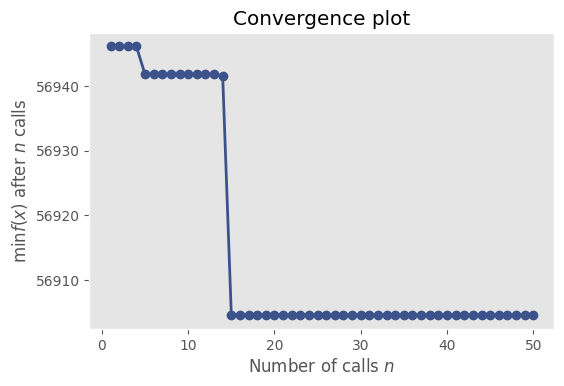

In [77]:
fig, ax = plt.subplots(figsize=(6, 3.84))
plot_convergence(resultados_opt, ax = ax);

**Búsqueda de hiperparámetros con Optuna**

In [78]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    
    modelo__alpha = trial.suggest_float("modelo__alpha", 1e-6, 1e+3, log=True)
    pipe.set_params(**{'modelo__alpha':modelo__alpha})
    score = -np.mean(cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)
print(study.best_trial)
print("")
print(f"Mejor score validación: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")

Best trial: 31. Best value: 56904.7: 100%|██████████| 50/50 [00:04<00:00, 10.59it/s]

FrozenTrial(number=31, state=TrialState.COMPLETE, values=[56904.656419143124], datetime_start=datetime.datetime(2023, 11, 26, 20, 41, 5, 257916), datetime_complete=datetime.datetime(2023, 11, 26, 20, 41, 5, 347791), params={'modelo__alpha': 4.603046006125831}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'modelo__alpha': FloatDistribution(high=1000.0, log=True, low=1e-06, step=None)}, trial_id=31, value=None)

Mejor score validación: 56904.656419143124
Mejores hiperparámetros: {'modelo__alpha': 4.603046006125831}


## Tuning (ajuste) del preprocesado

En la mayoría de casos, el proceso de optimización se centra en los hiperparámetros del modelo. Sin embargo, también puede ser muy interesante comparar diferentes transformaciones de preprocesado. Gracias a los pipeline, esto puede hacerse de la misma forma que con los hiperparametros. Véase el siguiente ejemplo en el que se compara el incorporar interacciones entre predictores.

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_selector

**Pipe: preprocesado + modelo**

- Transformaciones para las variables numéricas

In [80]:
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

- Transformaciones para las variables categóricas

In [81]:
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

- Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.

In [82]:
pipe = Pipeline(
        [('preprocessing', preprocessor),
        ('interactions', PolynomialFeatures(degree=2)),
        ('modelo', Ridge())])

- Grid de hiperparámetros

In [83]:
param_grid = {'interactions': [PolynomialFeatures(degree=2), 'passthrough'],
              'modelo__alpha': np.logspace(-5, 3, 10)}

- Búsqueda por validación cruzada

In [84]:
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['metros_totales',
                                                                          'antiguedad',
                                                                          'precio_terreno',
                                                                          'metros_habitables',
                                                                          'universitarios',
                               

- Resultatos del grid

In [85]:
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_interactions,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
16,passthrough,2.154435,-57143.233145,3664.555722,-55918.482036,935.538264


## Algoritmos

En los siguientes apartados se entrenan diferentes modelos de machine learning con el objetivo de compararlos e identificar el que mejor resultado obtiene en predecir el precio de las viviendas.

## K-Nearest Neighbor (kNN)

K-Nearest Neighbor es uno de los algoritmos de machine learning más simples. Su funcionamiento es el siguiente: para predecir una observación se identifican las K observaciones del conjunto de entrenamiento que más se asemejan a ella (en base a sus predictores) y se emplea como valor predicho el promedio de la variable respuesta en dichas observaciones. Dada su sencillez, suele dar peores resultados que otros algoritmos, pero es un buen referente como *baseline*.

In [86]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__n_neighbors': np.linspace(1, 100, 500, dtype=int)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_neighbors,mean_test_score,std_test_score,mean_train_score,std_train_score
5,26,-61639.44371,4105.200781,-59057.61091,1111.975615


**Resultados del grid**

**Gráfico resultados validación cruzada para cada hiperparámetro**

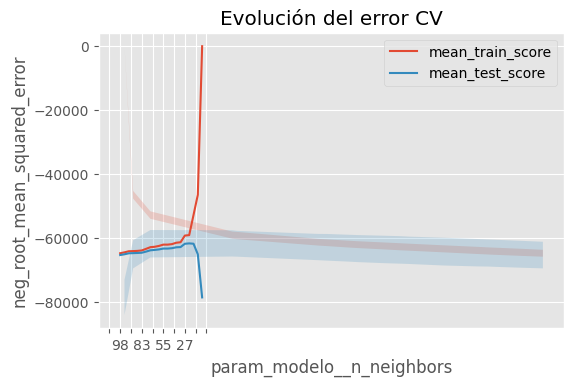

In [87]:
fig, ax = plt.subplots(figsize=(6, 3.84))
hiperparametro = 'param_modelo__n_neighbors'
resultados = resultados.sort_values(hiperparametro, ascending = False)
metrica    = grid.scoring

resultados.plot(hiperparametro, 'mean_train_score', ax=ax)
resultados.plot(hiperparametro, 'mean_test_score', ax=ax)
ax.fill_between(resultados[hiperparametro].astype(int),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados[hiperparametro].astype(int),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel(metrica);

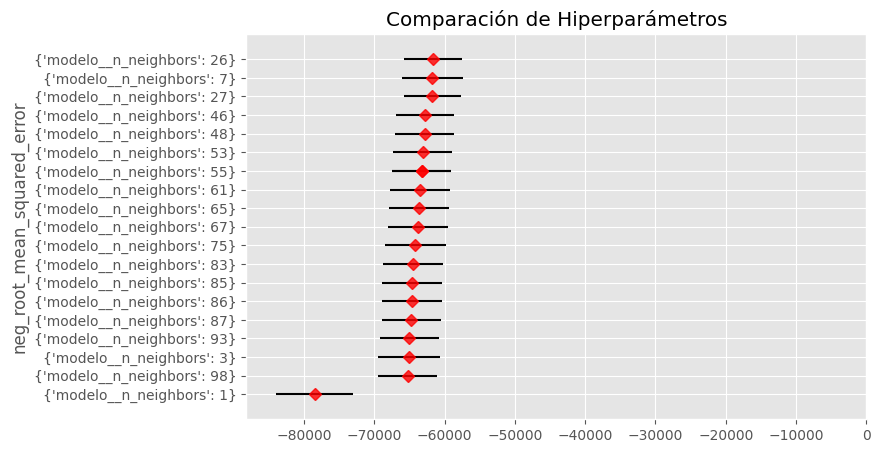

In [88]:
fig, ax = plt.subplots(figsize=(8, 5))
resultados = resultados.sort_values('mean_test_score', ascending = True)
ax.barh(
    [str(d) for d in resultados['params']],
    resultados['mean_test_score'],
    xerr=resultados['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    resultados['mean_test_score'],
    [str(d) for d in resultados['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Comparación de Hiperparámetros')
ax.set_ylabel(metrica);

Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el `GridSearchCV()` se indica `refit=True`, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.

**Error de test del modelo final**

In [89]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")

El error (rmse) de test es: 67631.40888902951


## Regresión lineal (Ridge y Lasso)

La regresión lineal es un método estadístico que trata de modelar la relación lineal entre una variable continua (variable dependiente, respuesta o dependiente) y una o más variables independientes (regresores o predictores) mediante el ajuste de una ecuación lineal. Se llama regresión lineal simple cuando solo hay una variable independiente y regresión lineal múltiple cuando hay más de una.

Además, el modelo lineal puede incluir regularización durante su ajuste, por lo que también incluye los modelos `ridge regression`, `lasso` y `elastic net`.

**`Scikit-Learn`** incorpora 3 tipos de regularización para los modelos lineales con el objetivo de evitar overfitting (sobreajuste), reducir varianza y atenuar el efecto de la correlación entre predictores. Por lo general, aplicando regularización se consigue modelos con mayor poder predictivo (generalización).

- El modelo **lasso** es un modelo lineal por mínimos cuadrados que incorpora una regularización que penaliza la suma del valor absolutos de los coeficientes de regresión ($  \left\|\beta  \right\|_{1}=\sum_{k=1}^{p}\left|\beta _{k} \right| $). A esta penalización se le conoce como *l1* y tiene el efecto de forzar a que los coeficientes de los predictores tiendan a cero. Dado que un predictor con coeficiente de regresión cero no influye en el modelo, lasso consigue seleccionar los predictores más influyentes. El grado de penalización está controlado por el hiperparámetro $ \lambda$. Cuando $ \lambda=0$, el resultado es equivalente al de un modelo lineal por mínimos cuadrados ordinarios. A medida que $ \lambda $ aumenta, mayor es la penalización y más predictores quedan excluidos.

- El modelo ridge es un modelo lineal por mínimos cuadrados que incorpora una regularización que penaliza la suma de los coeficientes elevados al cuadrado ($ \left\|\beta  \right\|_{2}^{2}=\sum_{k=1}^{p}\beta _{k}^{2}$). A esta penalización se le conoce como l2 y tiene el efecto de reducir de forma proporcional el valor de todos los coeficientes del modelo pero sin que estos lleguen a cero. Al igual que lasso, el grado de penalización está controlado por el hiperparámetro $\lambda$.

La principal diferencia práctica entre lasso y ridge es que el primero consigue que algunos coeficientes sean exactamente cero, por lo que realiza selección de predictores, mientras que el segundo no llega a excluir ninguno. Esto supone una ventaja notable de lasso en escenarios donde no todos los predictores son importantes para el modelo y se desea que los menos influyentes queden excluidos. Por otro lado, cuando existen predictores altamente correlacionados (linealmente), ridge reduce la influencia de todos ellos a la vez y de forma proporcional, mientras que lasso tiende a seleccionar uno de ellos, dándole todo el peso y excluyendo al resto. En presencia de correlaciones, esta selección varía mucho con pequeñas perturbaciones (cambios en los datos de entrenamiento), por lo que, las soluciones de lasso, son muy inestables si los predictores están altamente correlacionados.

Para conseguir un equilibrio óptimo entre estas dos propiedades, se puede emplear lo que se conoce como penalización *elastic net*, que combina ambas estrategias.

El modelo elastic net incluye una regularización que combina la penalización *l1* y *l2*  ($\alpha \lambda \left\|\beta  \right\|_{1}+\frac{1}{2}\left ( 1-\alpha  \right )\left\|\beta  \right\|_{2}^{2}$). El grado en que influye cada una de las penalizaciones está controlado por el hiperparámetro  $\alpha$. Su valor debe estar comprendido en el intervalo [0,1], cuando $\alpha = 0$, se aplica *ridge regression* y cuando $\alpha = 1$ se aplica *lasso*. La combinación de ambas penalizaciones suele dar lugar a buenos resultados. Una estrategia frecuentemente utilizada es asignarle casi todo el peso a la penalización *l1* ($\alpha$ muy próximo a 1) para conseguir seleccionar predictores y un poco a la *l2* para dar cierta estabilidad en el caso de que algunos predictores estén correlacionados. 

Encontrar el mejor modelo implica identificar los valores óptimos de los hiperparámetros de regularización $\alpha$ y $\lambda$.

In [90]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
10,3.396739,-57030.638109,4934.582681,-55925.35706,1262.718973


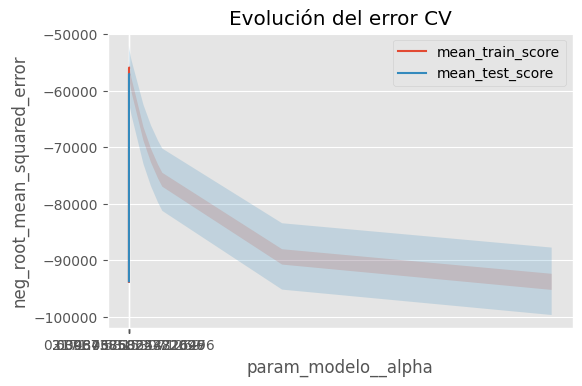

In [91]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))
hiperparametro = 'param_modelo__alpha'
resultados = resultados.sort_values(hiperparametro, ascending = False)
metrica    = grid.scoring

resultados.plot(hiperparametro, 'mean_train_score', ax=ax)
resultados.plot(hiperparametro, 'mean_test_score', ax=ax)
ax.fill_between(resultados[hiperparametro].astype(int),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados[hiperparametro].astype(int),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel(metrica);

In [92]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

El error (rmse) de test es: 65406.828942794586


## Random Forest

Un modelo Random Forest está formado por un conjunto de árboles de decisión individuales, cada uno entrenado con una muestra ligeramente distinta de los datos de entrenamiento generada mediante bootstrapping). La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo. Para conocer más sobre este tipo de modelo visitar Random Forest con Python.

In [93]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': [3, 5, 7, 1.0],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
12,2000,7,20,-54315.710497,5968.772616,-20200.384078,538.056087


In [94]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_rf = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_rf}")

El error (rmse) de test es: 61453.50236376489


## Gradient Boosting Trees

Un modelo Gradient Boosting Trees está formado por un conjunto de árboles de decisión individuales, entrenados de forma secuencial, de forma que cada nuevo árbol trata de mejorar los errores de los árboles anteriores. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': [3, 5, 7, 1.0],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_gbm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_gbm}")

## Stacking

A modo general, el término model ensembling hace referencia a la combinación de las predicciones de dos o más modelos distintos con el objetivo de mejorar las predicciones finales. Esta estrategia se basa en la asunción de que, distintos modelos entrenados independientemente, emplean distintos aspectos de los datos para realizar las predicciones, es decir, cada uno es capaz de identificar parte de la “verdad” pero no toda ella. Combinando la perspectiva de cada uno de ellos, se obtiene una descripción más detallada de la verdadera estructura subyacente en los datos. A modo de analogía, imagínese un grupo de estudiantes que se enfrentan a un examen multidisciplinal. Aunque todos obtengan aproximadamente la misma nota, cada uno de ellos habrá conseguido más puntos con las preguntas que tratan sobre las disciplinas en las que destacan. Si en lugar de hacer el examen de forma individual, lo hacen en grupo, cada uno podrá contribuir en los aspectos que más domina, y el resultado final será probablemente superior a cualquiera de los resultados individuales.

La clave para que el ensembling consiga mejorar los resultados es la diversidad de los modelos. Si todos los modelos combinados son similares entre ellos, no podrán compensarse unos a otros. Por esta razón, se tiene que intentar combinar modelos que sean lo mejor posible a nivel individual y lo más diferentes entre ellos.

Las formas más simples de combinar las predicciones de varios modelos es emplear la media para problemas de regresión y la moda para problemas de clasificación. Sin embargo existen otras aproximaciones más complejas capaces de conseguir mejores resultados:

- Ponderar las agregaciones dando distinto peso a cada modelo, por ejemplo, en proporción al accuracy que han obtenido de forma individual.

- Super Learner (stacked regression): emplear un nuevo modelo para que decida la mejor forma de combinar las predicciones de los otros modelos.


## Algoritmo Super Learner

La implementación de Super Learner disponible en scikit-learn en las clases `StackingRegressor` y `StackingClassifier` sigue el siguiente algoritmo:

**Definición del ensemble**

1. Definir un listado con los algoritmos base (cada uno con los hiperparámetros pertinentes).

2. Seleccionar el algoritmo de *metalearning* que defina cómo se entrena en modelo superior. Por defecto, se emplea `RidgeCV` para regresión y `LogisticRegression` para clasificación.

**Entrenamiento del ensemble**

1. Entrenar cada uno de los algoritmos base con el conjunto de entrenamiento.
2. Realizar k-fold cross-validation con cada uno de los algoritmos base y almacenar las predicciones hechas en cada una de las k particiones.
3. Combinar las predicciones del paso 2 en una única matriz NxL (N = número de observaciones en el conjunto de entrenamiento, L = número de modelos base).
4. Entrenar el metalearning con la variable respuesta y la matriz NxL como predictores.
5. El *Super learner* final está formado por los modelos base y el modelo *metalearning*.

**Predecir**

1. Predecir la nueva observación con cada uno de los modelos base.
2. Emplear las predicciones de los modelos base como input del metalearner para obtener la predicción final.

Se procede a crear un *stacking* con los modelos *Ridge* y *RandomForest*, empleando en cada caso lo mejores hiperparámetros encontrados en los apartados anteriores.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough',
                    verbose_feature_names_out = False
               ).set_output(transform="pandas")

# Se combinan los pasos de preprocesado y los modelos creando varios pipeline.
pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', Ridge(alpha=3.4))])

pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestRegressor(
                                         n_estimators = 1000,
                                         max_features = 7,
                                         max_depth    = 20
                                        )
                     )])

In [ ]:
# Definición y entrenamiento del StackingRegressor
# ==============================================================================
estimators = [('ridge', pipe_ridge),
              ('random_forest', pipe_rf)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_regressor.fit(X = X_train, y = y_train)

In [ ]:
# Error de test del stacking
# ==============================================================================
modelo_final = stacking_regressor
predicciones = modelo_final.predict(X = X_test)
rmse_stacking = mean_squared_error(
                    y_true  = y_test,
                    y_pred  = predicciones,
                    squared = False
                  )
print(f"El error (rmse) de test es: {rmse_stacking}")

## Comparación

Se compara el error de test de todos los modelos entrenados.

In [ ]:
error_modelos = pd.DataFrame({
                        'modelo': ['knn', 'lm', 'random forest', 'gradient boosting',
                                   'stacking'],
                        'rmse': [rmse_knn, rmse_lm, rmse_rf, rmse_gbm, rmse_stacking]
                     })
error_modelos = error_modelos.sort_values('rmse', ascending=False)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.rmse)
ax.plot(error_modelos.rmse, error_modelos.modelo, "o", color='black')
ax.tick_params(axis='y', which='major', labelsize=12)
ax.set_title('Comparación de error de test modelos'),
ax.set_xlabel('Test rmse');

In [ ]:
import session_info
session_info.show(html=False)